**Preliminares:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
import random as rd
from scipy.misc import derivative

**Funciones SSH:**

In [2]:
def H_t1_t2(N, t1, t2, PBC = False):
    Matriz = np.zeros((N,N))

    a = 0 #diagonal
    b = -t2 #1 + delta #la que aparece despues - en este caso sería -t2
    c = t1 #1 - delta #la que aparece primero - en este caso sería t1

    for i in range(N):
        Matriz[i,i] = a
    for i in range(N-1):
        if (i%2 == 0):
            Matriz[i+1,i] = c
            Matriz[i,i+1] = c
        else:
            Matriz[i+1,i] = b
            Matriz[i,i+1] = b
            
    if PBC:
        Matriz[0,N-1] = b #PBC
        Matriz[N-1,0] = b #PBC
            
    return Matriz  

def Diagonalizar(Matriz):
    
    eig_vals, eig_vecs = np.linalg.eig(Matriz)
    eig_vals_sorted = np.sort(eig_vals)
    eig_vecs_sorted = eig_vecs[:, eig_vals.argsort()]
    
    N = Matriz.shape[0]
    D = np.identity(N)*eig_vals_sorted
    Q = np.asmatrix(eig_vecs_sorted)

    return D, Q, np.asmatrix(Matriz)

def Estado_Base(D,U):
    i = 0
    while D[i,i] <= 0:
        i = i +1
    indice = i #Ese es la energía del estado base:    
    Vec_Est_Base = U[:,indice]
    lambda_base = D[indice,indice]
    
    return Vec_Est_Base/np.linalg.norm(Vec_Est_Base), lambda_base #Retornemoslo normalizado

**Coeficientes de Lanczos**

Supongamos que conocemos los momentos:

In [3]:
M = [1, 2, 120, 4, 7] #M_0, M_1, M_2, M_3, M_4

In [4]:
def M_sub_k_sup_n(k,n):    
    if(n == 0): return ((-1)**k)*M[k]
    else: return L_sub_k_sup_n(k, n-1) - L_sub_k_sup_n(n - 1, n-1)*(M_sub_k_sup_n(k, n-1)/M_sub_k_sup_n(n-1,n-1))

def L_sub_k_sup_n(k,n):   
    if(n == 0): return ((-1)**(k+1))*M[k+1]
    else: return (M_sub_k_sup_n(k+1, n)/M_sub_k_sup_n(n,n)) - (M_sub_k_sup_n(k, n-1)/M_sub_k_sup_n(n-1,n-1))

def a_n(n):
    return -1*L_sub_k_sup_n(n,n)

def b_n_cuadrado(n):
    return M_sub_k_sup_n(n,n)

**Testeo de las relaciones de recurrencia:**

In [5]:
a_n(1)

-4.0344827586206895

In [6]:
(M[3] - M[1]**3)/(M[2] - M[1]**2) -2*M[1]

-4.0344827586206895

In [7]:
M[3]

4

In [8]:
b_n_cuadrado(1)

116.0

In [9]:
(M[2] - M[1]**2)**0.5

10.770329614269007

In [10]:
((M[4] - M[1]*M[3])/(M[2] - M[1]**2) - M[2] -1*((M[1]**3 - M[3])/(M[2] - M[1]**2) +2*M[1])*((M[1]**3 - M[3])/(M[2] - M[1]**2) + M[1]))

-128.2167063020214

In [11]:
b_n_cuadrado(2)

-128.2167063020214

In [12]:
for i in range(100):
    global M
    M = [1] + [rd.randint(1,200) for n in range(4)] #M_0, M_1, M_2, M_3, M_4
    
    if not(np.isclose(a_n(0), M[1])): print('Está fallando')
    if not(np.isclose(a_n(1), (M[3] - M[1]**3)/(M[2] - M[1]**2) -2*M[1])): print('Está fallando')
    if not(np.isclose(b_n_cuadrado(0), 1)): print('Está fallando')
    if not(np.isclose(b_n_cuadrado(1), (M[2] - M[1]**2))): print('Está fallando')
    if not(np.isclose(b_n_cuadrado(2), ((M[4] - M[1]*M[3])/(M[2] - M[1]**2) - M[2] -1*((M[1]**3 - M[3])/(M[2] - M[1]**2) +2*M[1])*((M[1]**3 - M[3])/(M[2] - M[1]**2) + M[1])))): print('Está fallando') 

Las relaciones funcionan bien, hagamos una función que permita calcular los coeficientes:

In [13]:
def a_coef():
    coef = []
    for i in range(len(M)):
        try: coef.append(a_n(i))
        except: break
    return coef    

def b_coef_cuadrado():
    coef = []
    for i in range(len(M)):
        try: coef.append(b_n_cuadrado(i))
        except: break
    return coef   

In [14]:
M = [1, 2, 120, 4, 7, 9]

In [15]:
[a_n(0), a_n(1), a_n(2)], a_coef()

([2, -4.0344827586206895, 2.0662873774544583],
 [2, -4.0344827586206895, 2.0662873774544583])

In [16]:
[b_n_cuadrado(0), b_n_cuadrado(1), b_n_cuadrado(2)], b_coef_cuadrado()

([1, 116.0, -128.2167063020214], [1, 116.0, -128.2167063020214])

**Testeo (8. Time evolution of spread complexity in quenched - Mir Afrasiar):**

In [17]:
def S(t):
    global q1_f, q2_f, k
    
    r1 = q1_f - q2_f*np.cos(k)
    r3 = q2_f*np.sin(k)
    rf = np.sqrt(r1**2 + r3**2)
    cos_thetaf = r3/rf
    sin_thetaf = np.abs(r1)/rf
    
    return np.cos(rf*t) - 1j*cos_thetaf*np.sin(rf*t)

def LE(t):
    return -1*np.log10(np.abs(S(tiempos)))

def a_0(q1_f, q2_f, k):
    r1 = q1_f - q2_f*np.cos(k)
    r3 = q2_f*np.sin(k)
    rf = np.sqrt(r1**2 + r3**2)
    cos_thetaf = r3/rf
    
    return -1*rf*cos_thetaf

def a_1(q1_f, q2_f, k):
    r1 = q1_f - q2_f*np.cos(k)
    r3 = q2_f*np.sin(k)
    rf = np.sqrt(r1**2 + r3**2)
    cos_thetaf = r3/rf
    
    return rf*cos_thetaf

def b_1(q1_f, q2_f, k):
    r1 = q1_f - q2_f*np.cos(k)
    r3 = q2_f*np.sin(k)
    rf = np.sqrt(r1**2 + r3**2)
    sin_thetaf = np.abs(r1)/rf
    
    return rf*np.abs(sin_thetaf)

**Prueba 1:**

In [18]:
q1_f, q2_f, k = -1, 3, np.pi/2

/home/joaco/anaconda3/envs/root_lab/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


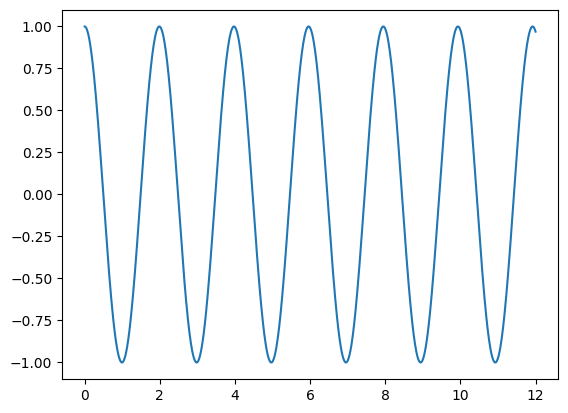

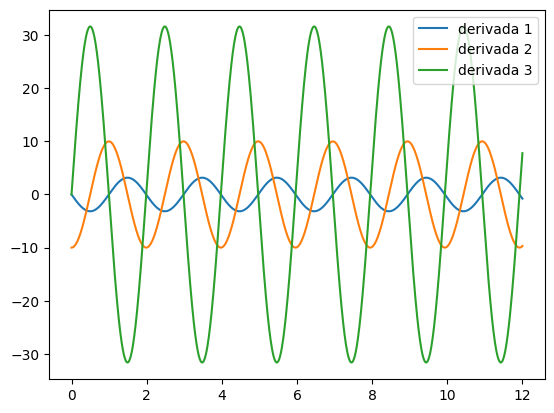

In [19]:
tiempos = np.linspace(0,12,1000)
plt.plot(tiempos, S(tiempos))
fig = plt.figure()
for degree in range(1,4):
    plt.plot(tiempos, derivative(S, x0 = tiempos, dx= 0.01, n = degree , order = 6 + 1), label = f'derivada {degree}')
plt.legend()

In [20]:
M = [1]

for degree in range(1,4):
    M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = 6 + 1))
M

[1,
 (-2.9999999999785762+5.898059818321144e-15j),
 (9.999999999980961+1.3010426069826053e-14j),
 (-29.999998250308103+1.3877787807814455e-11j)]

In [21]:
a_coef()

[(-2.9999999999785762+5.898059818321144e-15j),
 (3.0000017493991207+1.3851940341834923e-11j)]

In [22]:
a_0(q1_f, q2_f, k), a_1(q1_f, q2_f, k)

(-3.0, 3.0)

In [23]:
b_n_cuadrado(1)

(1.0000000001095035+4.83987849795002e-14j)

In [24]:
b_1(q1_f, q2_f, k)**2

1.0000000000000004

**Prueba 2:**

In [25]:
q1_f, q2_f, k = 1, 1.5, np.pi

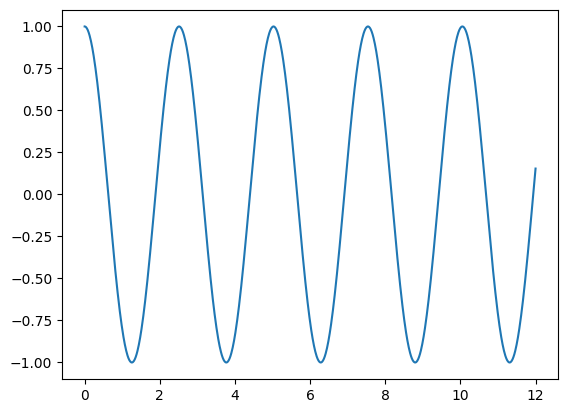

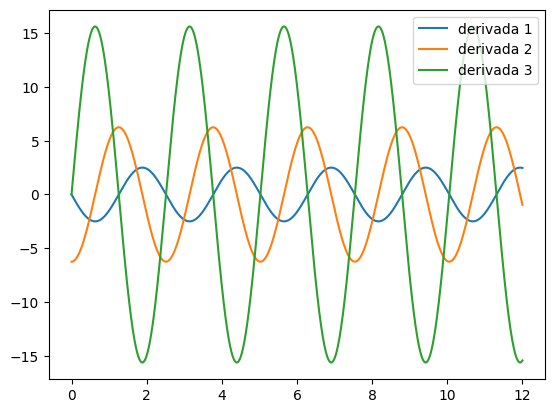

In [26]:
tiempos = np.linspace(0,12,1000)
plt.plot(tiempos, S(tiempos))
fig = plt.figure()
for degree in range(1,4):
    plt.plot(tiempos, derivative(S, x0 = tiempos, dx= 0.01, n = degree , order = 6 + 1), label = f'derivada {degree}')
plt.legend()

In [27]:
M = [1]

for degree in range(1,4):
    M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = 6 + 1))
M

[1,
 (-1.8369701987178267e-16-0j),
 (6.249999999999017-1.2037062152420224e-31j),
 (-1.1481063480415434e-15-2.775557561562891e-11j)]

In [28]:
a_coef()

[(-1.8369701987178267e-16+0j), (1.8369702405688947e-16-4.440892098501324e-12j)]

In [29]:
a_0(q1_f, q2_f, k), a_1(q1_f, q2_f, k)

(-1.8369701987210297e-16, 1.8369701987210297e-16)

In [30]:
b_coef_cuadrado()

[1, (6.249999999999017-1.2037062152420224e-31j)]

In [31]:
1, b_1(q1_f, q2_f, k)**2

(1, 6.25)

Tratemos de graficar esto para distintos q:

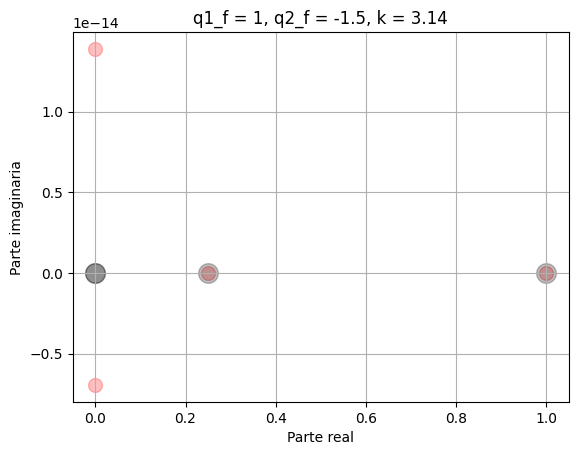

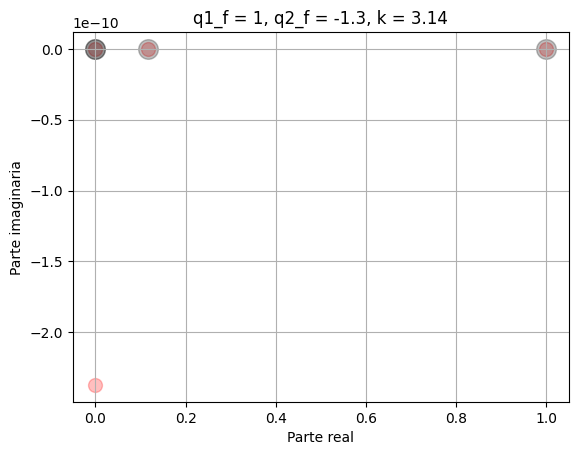

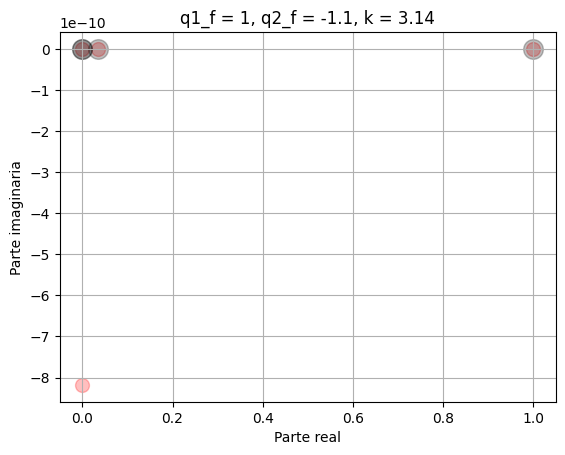

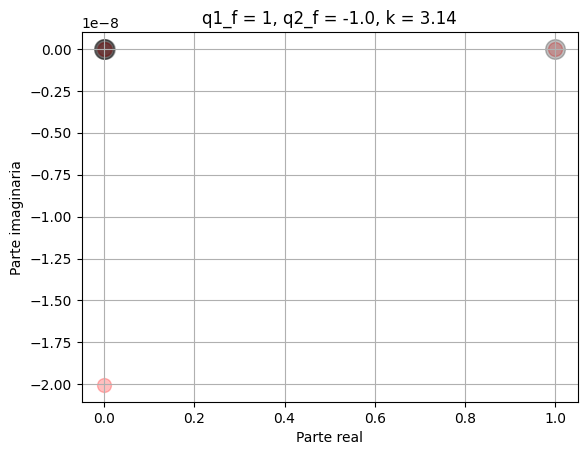

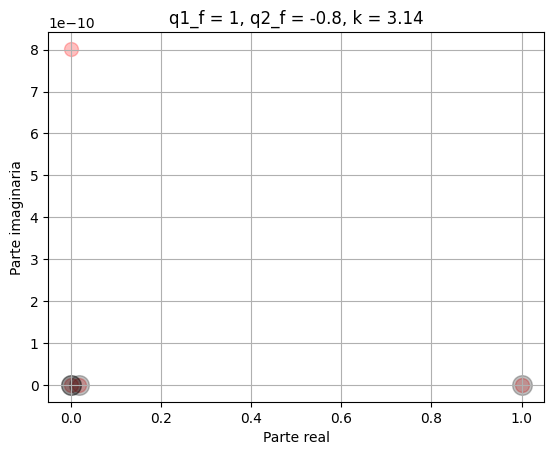

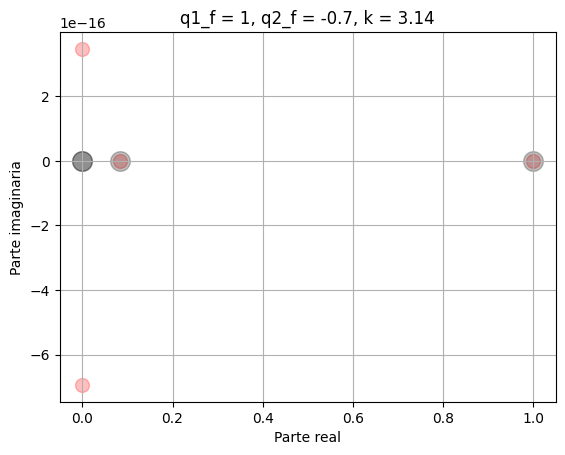

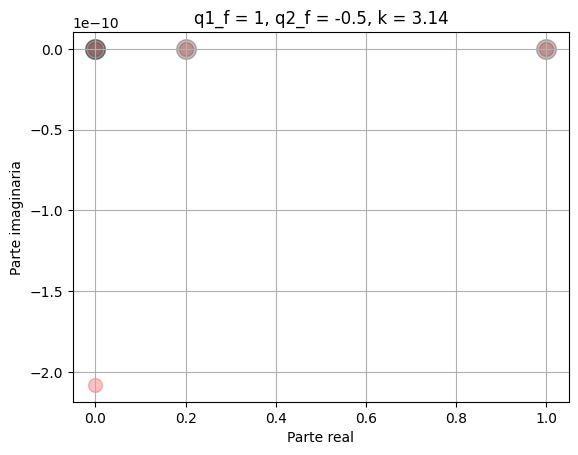

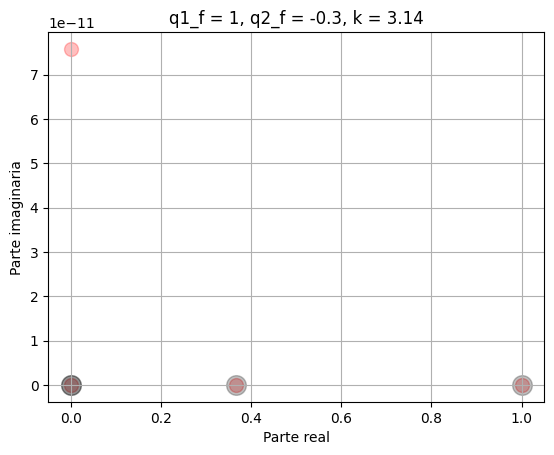

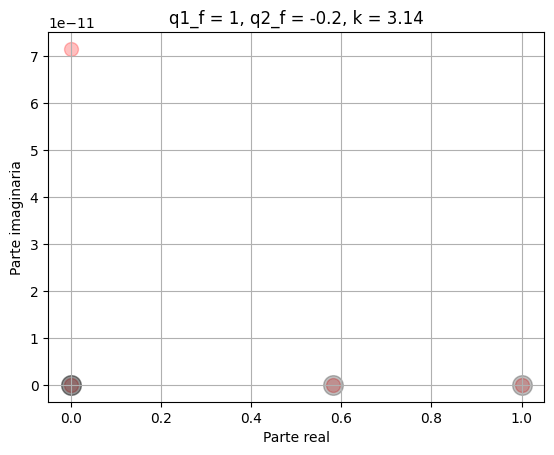

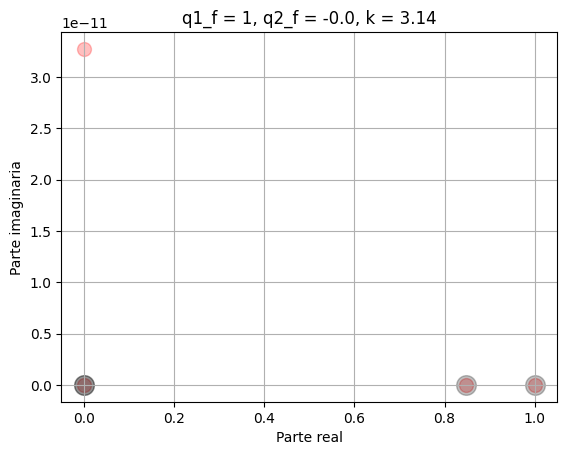

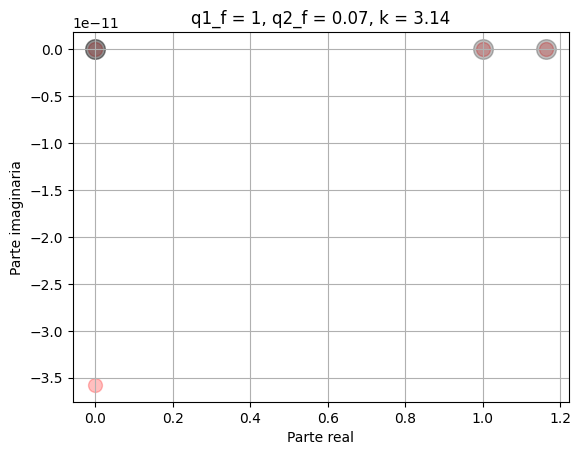

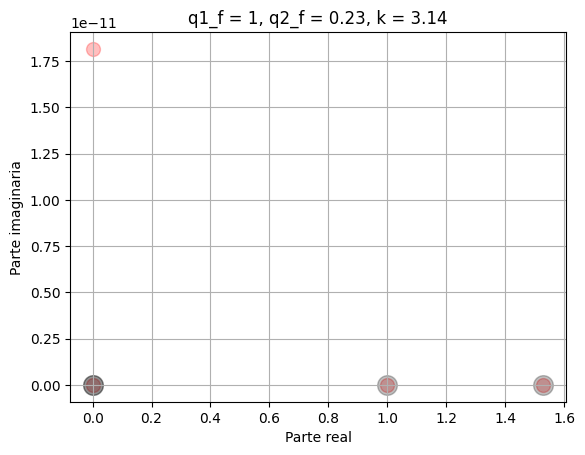

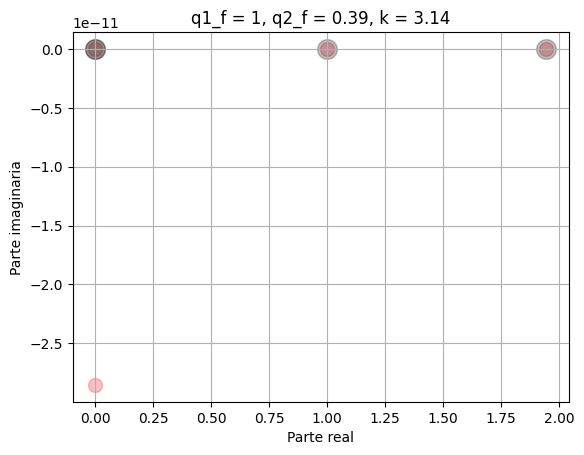

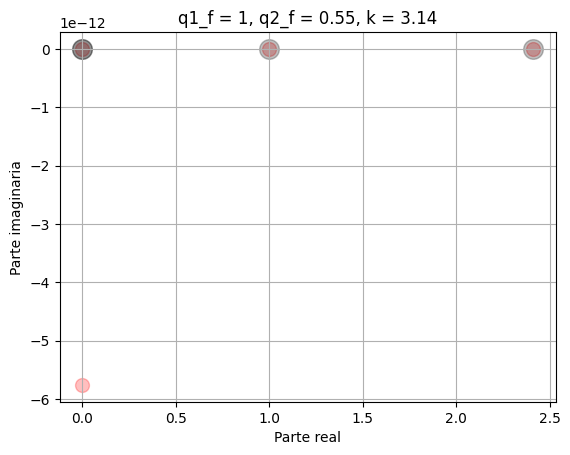

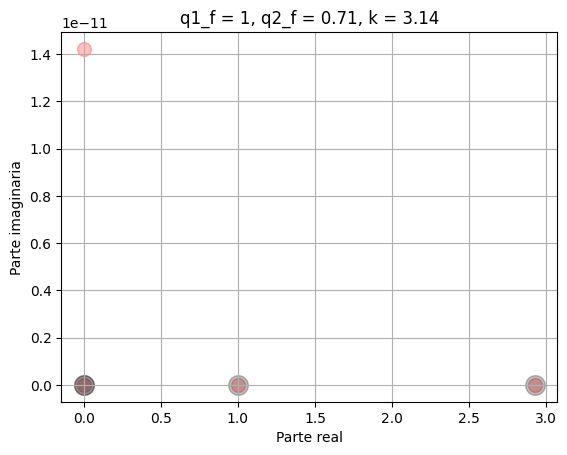

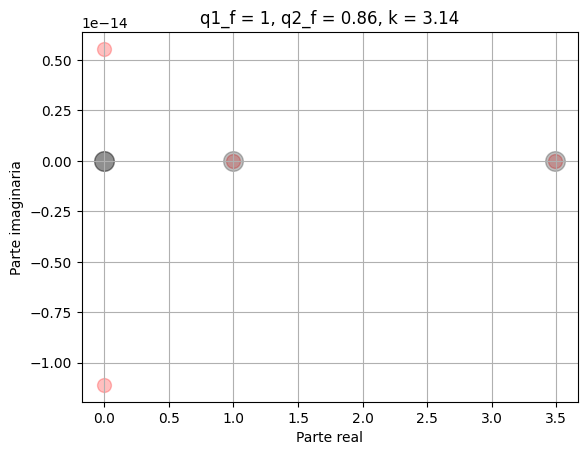

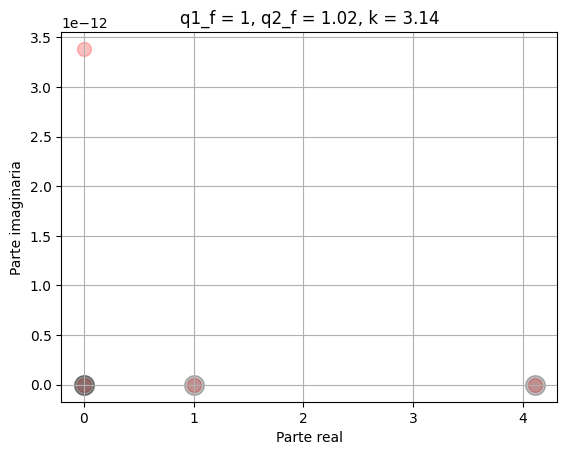

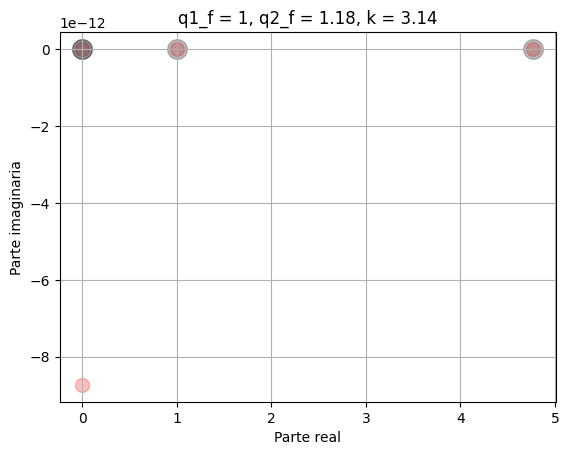

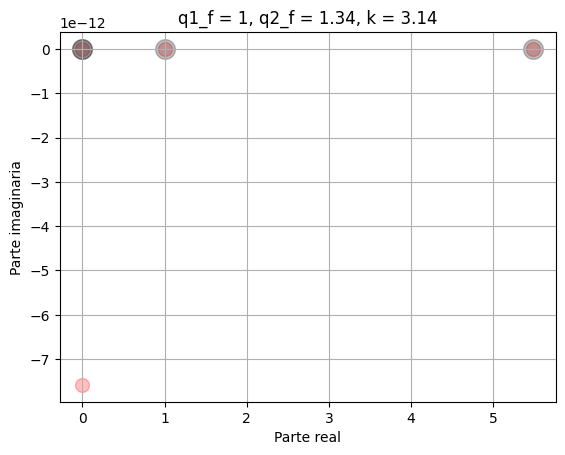

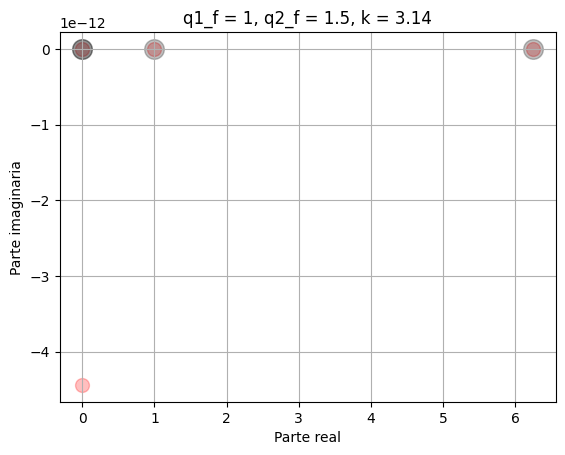

In [32]:
q2_f_values = np.linspace(-1.5,1.5, 20)

for q2_f in q2_f_values:

    q1_f, k = 1, np.pi
    
    fig = plt.figure()

    M = [1]
    for degree in range(1,4):
        M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = 6 + 1))

    coef_calculados = a_coef() + b_coef_cuadrado()

    for coef in coef_calculados:
        plt.scatter(coef.real, coef.imag, color = 'red', alpha = 0.25, s = 100)

    coef_teoricos = [a_0(q1_f, q2_f, k), a_1(q1_f, q2_f, k)] + [1, b_1(q1_f, q2_f, k)**2]

    for coef in coef_teoricos:
        plt.scatter(coef.real, coef.imag, color = 'black', alpha = 0.25, s = 200)

    plt.grid()
    #plt.ylim(-0.1,0.1)
    plt.title(f'q1_f = {q1_f}, q2_f = {str(q2_f)[:4]}, k = {str(k)[:4]}', fontsize = 12)
    plt.xlabel('Parte real')
    plt.ylabel('Parte imaginaria')

**Observación:** Funciona bien, sin embargo hay que tener cuidado con las derivadas que calcula python. Si calculo más M me pueden aparecer M que divergen y coeficientes que nada que ver.

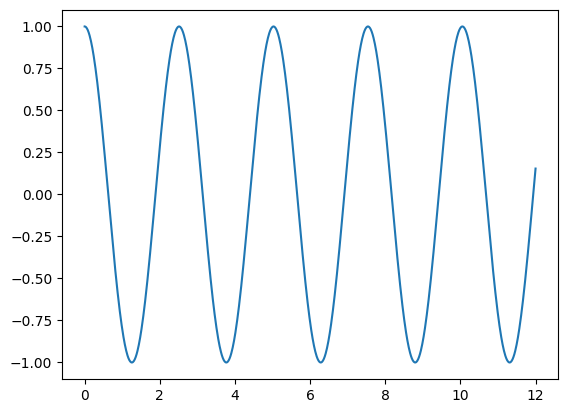

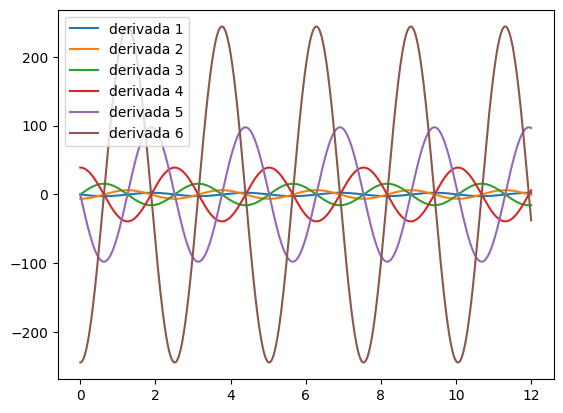

In [33]:
tiempos = np.linspace(0,12,1000)
plt.plot(tiempos, S(tiempos))
fig = plt.figure()

M = [1]

for degree in range(1,7):
    M.append(((-1j)**degree)*derivative(S, x0 = 0, dx= 0.01, n = degree , order = 6 + 1))
    plt.plot(tiempos, derivative(S, x0 = tiempos, dx= 0.01, n = degree , order = 6 + 1), label = f'derivada {degree}')
plt.legend()

In [34]:
a_coef()

[(-1.8369701987178267e-16+0j),
 (1.8369702405688947e-16-4.440892098501324e-12j),
 (-2.6326895919498096e-12-0.0006111621372564333j)]

In [35]:
b_coef_cuadrado()

[1,
 (6.249999999999017-1.2037062152420224e-31j),
 (-9.082884400157808e-08+1.5407680333512825e-26j),
 (65945.20442389806+3.5111734921424246e-14j)]

**Idea:** Esto depronto se puede arreglar calculando ambos coeficientes al mismo tiempo, cuando el b valga cero entonces se acaba todo, así nada diverge.